In [2]:
import os
import numpy as np
import cv2
import tifffile as tiff
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

In [3]:
# Define directories (use relative paths or configure as needed)
image_dir = r"E:\Cellula Tasks\Week 3\data-20250216T183649Z-001\data\images"
label_dir = r"E:\Cellula Tasks\Week 3\data-20250216T183649Z-001\data\labels"


In [4]:
# Data loading function
def load_images(image_dir, label_dir):
    """Load multi-spectral images and corresponding masks"""
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
    label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.png')])
    
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, label_paths):
        try:
            img = tiff.imread(img_path)  # Load multi-spectral image
            if img.ndim == 3 and img.shape[-1] == 12:  # Ensure 12 bands
                images.append(img)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask is not None:
                    masks.append(mask)
                else:
                    print(f"Skipping invalid mask: {mask_path}")
            else:
                print(f"Skipping image with incorrect bands: {img_path}")
        except Exception as e:
            print(f"Error loading {img_path} or {mask_path}: {e}")
    
    return np.array(images), np.array(masks)


In [5]:
# Preprocessing functions
def normalize_image(image):
    """Normalize image to 0-1 range with epsilon to avoid division by zero"""
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val + 1e-8)

def contrast_stretching(image):
    """Apply contrast stretching using 2nd and 98th percentiles"""
    p2, p98 = np.percentile(image, (2, 98))
    return np.clip((image - p2) / (p98 - p2 + 1e-8), 0, 1)

# Load and preprocess data
images, masks = load_images(image_dir, label_dir)
processed_images = np.array([contrast_stretching(normalize_image(img)) for img in images])
y_masks = np.array([cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST) for mask in masks])
y_masks = (y_masks > 0).astype(np.float32)[..., np.newaxis]  # Binarize and add channel

# Verify shapes
print(f"Processed images shape: {processed_images.shape}")
print(f"Processed masks shape: {y_masks.shape}")


Processed images shape: (306, 128, 128, 12)
Processed masks shape: (306, 128, 128, 1)


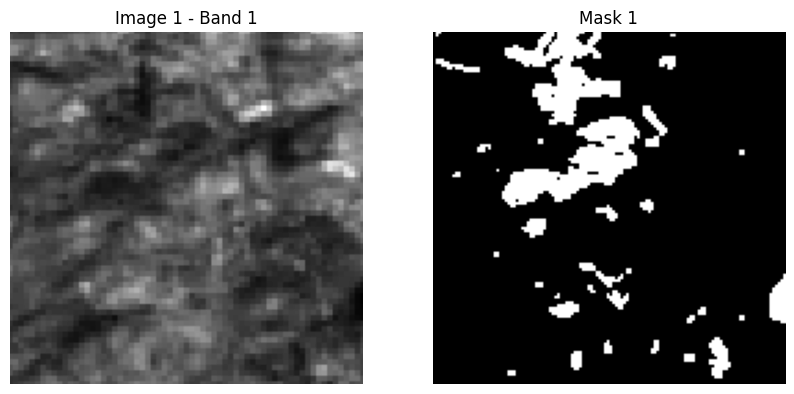

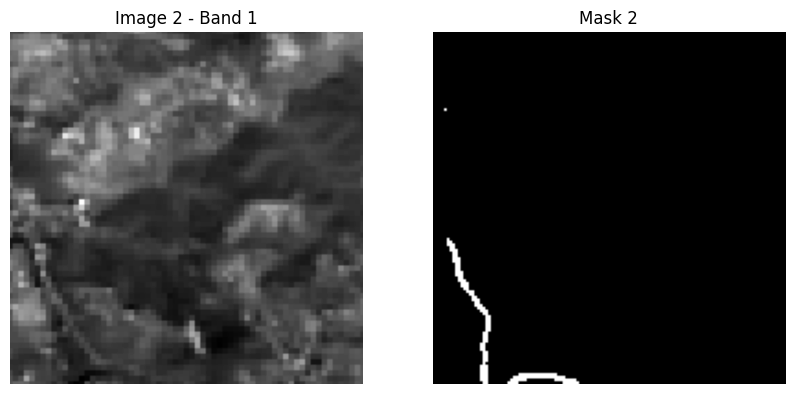

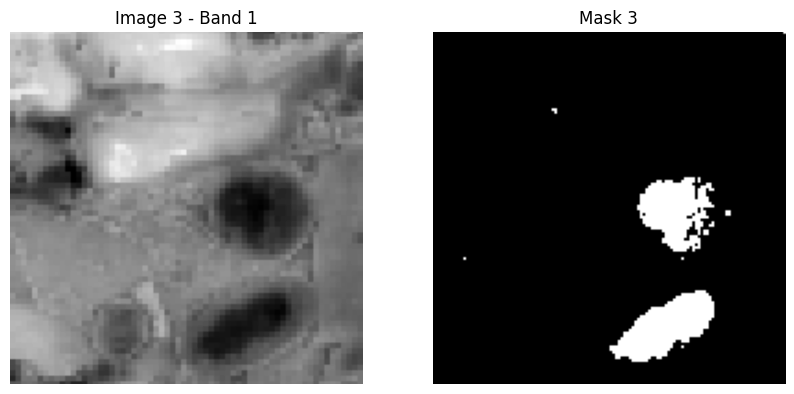

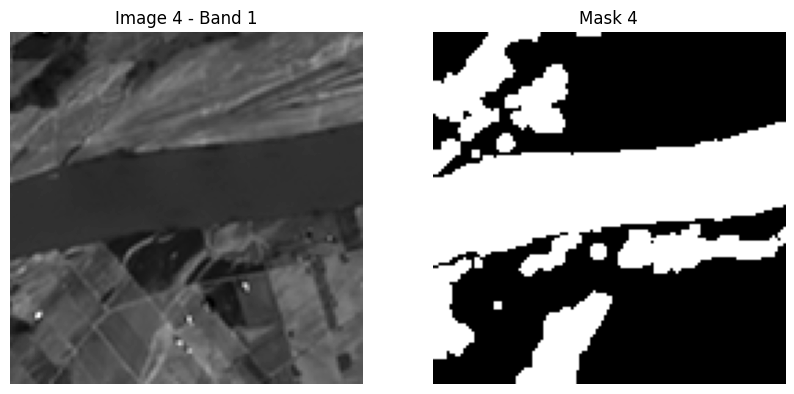

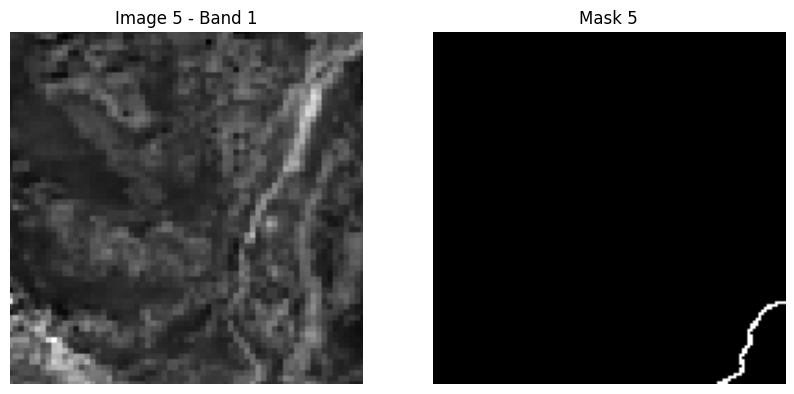

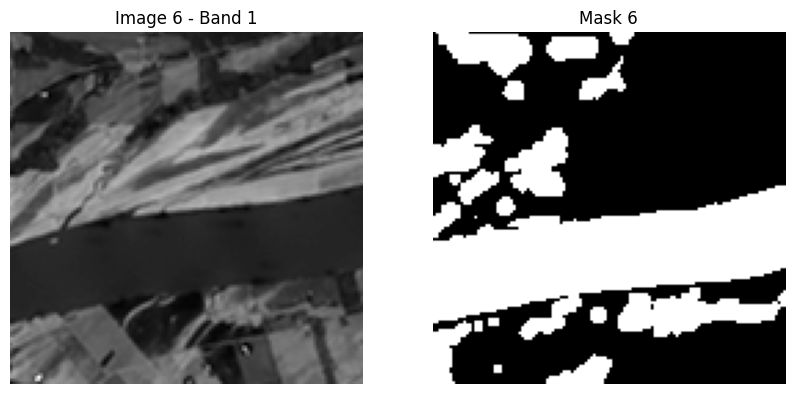

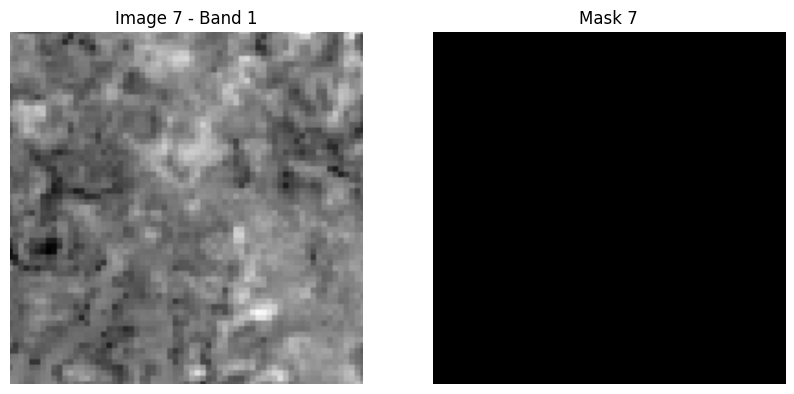

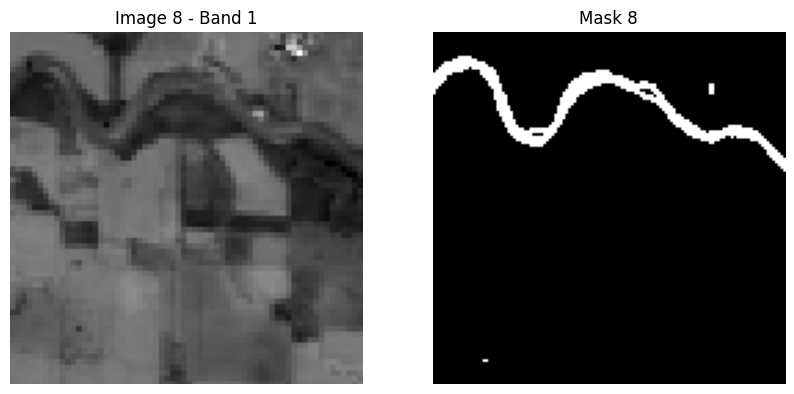

In [6]:
# Visualize first 4 samples
for i in range(min(8, len(processed_images))):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(processed_images[i][:, :, 0], cmap='gray')  # Show first band
    plt.title(f"Image {i+1} - Band 1")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(y_masks[i].squeeze(), cmap='gray')
    plt.title(f"Mask {i+1}")
    plt.axis('off')
    plt.show()

In [7]:
# Custom Dataset for PyTorch
class CustomDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].transpose(2, 0, 1)  # Convert to (C, H, W) - 12 channels
        mask = self.masks[idx].transpose(2, 0, 1)    # Convert to (1, H, W)
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        return image, mask

In [8]:
# Create dataset and split
dataset = CustomDataset(processed_images, y_masks)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [9]:
# Define U-Net model for 12-channel input
class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        # Decoder
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        # Bottleneck
        b = self.bottleneck(p2)
        # Decoder
        u2 = self.upconv2(b)
        cat2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(cat2)
        u1 = self.upconv1(d2)
        cat1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(cat1)
        out = self.final_conv(d1)
        return out
# Create model instance
model = UNet(in_channels=12, out_channels=1)

# Print model summary
summary(model, input_size=(12, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,976
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [10]:
# Initialize model, loss, and optimizer
model = UNet(in_channels=12, out_channels=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


UNet(
  (enc1): Sequential(
    (0): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (upconv2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (dec2): Sequential(
    (0): Conv2d(2

In [11]:
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

print("Training complete!")

Epoch 1/30, Train Loss: 0.6629, Val Loss: 0.5785
Epoch 2/30, Train Loss: 0.5088, Val Loss: 0.4434
Epoch 3/30, Train Loss: 0.3965, Val Loss: 0.3525
Epoch 4/30, Train Loss: 0.3667, Val Loss: 0.3001
Epoch 5/30, Train Loss: 0.3036, Val Loss: 0.2721
Epoch 6/30, Train Loss: 0.3010, Val Loss: 0.2636
Epoch 7/30, Train Loss: 0.2850, Val Loss: 0.2485
Epoch 8/30, Train Loss: 0.2891, Val Loss: 0.2590
Epoch 9/30, Train Loss: 0.2767, Val Loss: 0.2458
Epoch 10/30, Train Loss: 0.2698, Val Loss: 0.2477
Epoch 11/30, Train Loss: 0.2645, Val Loss: 0.2525
Epoch 12/30, Train Loss: 0.2643, Val Loss: 0.2508
Epoch 13/30, Train Loss: 0.2685, Val Loss: 0.2480
Epoch 14/30, Train Loss: 0.2697, Val Loss: 0.2464
Epoch 15/30, Train Loss: 0.2603, Val Loss: 0.2367
Epoch 16/30, Train Loss: 0.2510, Val Loss: 0.2393
Epoch 17/30, Train Loss: 0.2510, Val Loss: 0.2405
Epoch 18/30, Train Loss: 0.2491, Val Loss: 0.2331
Epoch 19/30, Train Loss: 0.2461, Val Loss: 0.2397
Epoch 20/30, Train Loss: 0.2430, Val Loss: 0.2294
Epoch 21/

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Threshold for converting probabilities to binary predictions
threshold = 0.5

In [13]:
def calculate_iou(preds, masks, epsilon=1e-6):
    """Calculate IoU for a batch of images"""
    preds = preds.float()
    masks = masks.float()
    intersection = (preds * masks).sum(dim=[2, 3])  # Sum over height and width
    union = preds.sum(dim=[2, 3]) + masks.sum(dim=[2, 3]) - intersection
    iou = (intersection + epsilon) / (union + epsilon)  # Add epsilon to avoid division by zero
    return iou.cpu().numpy()

def calculate_dice(preds, masks, epsilon=1e-6):
    """Calculate Dice coefficient for a batch of images"""
    preds = preds.float()
    masks = masks.float()
    intersection = (preds * masks).sum(dim=[2, 3])
    dice = (2. * intersection + epsilon) / (preds.sum(dim=[2, 3]) + masks.sum(dim=[2, 3]) + epsilon)
    return dice.cpu().numpy()

def calculate_accuracy(preds, masks):
    """Calculate pixel accuracy for a batch of images"""
    correct = (preds == masks).float().sum(dim=[2, 3])
    total = masks.shape[2] * masks.shape[3]  # Total number of pixels per image
    accuracy = correct / total
    return accuracy.cpu().numpy()

In [14]:
# Lists to store metrics for all test images
ious = []
dices = []
accuracies = []

# Disable gradient computation for efficiency
with torch.no_grad():
    for images, masks in test_loader:
        # Move data to the correct device
        images = images.to(device)
        masks = masks.to(device)
        
        # Get model predictions
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > threshold).float()
        
        # Calculate metrics for each image in the batch
        ious_batch = calculate_iou(preds, masks)
        dices_batch = calculate_dice(preds, masks)
        accuracies_batch = calculate_accuracy(preds, masks)
        
        # Store metrics
        ious.extend(ious_batch)
        dices.extend(dices_batch)
        accuracies.extend(accuracies_batch)

# Calculate average metrics across all test images
avg_iou = np.mean(ious)
avg_dice = np.mean(dices)
avg_accuracy = np.mean(accuracies)

# Print results
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average Dice: {avg_dice:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")

Average IoU: 0.5317
Average Dice: 0.6049
Average Accuracy: 0.8993


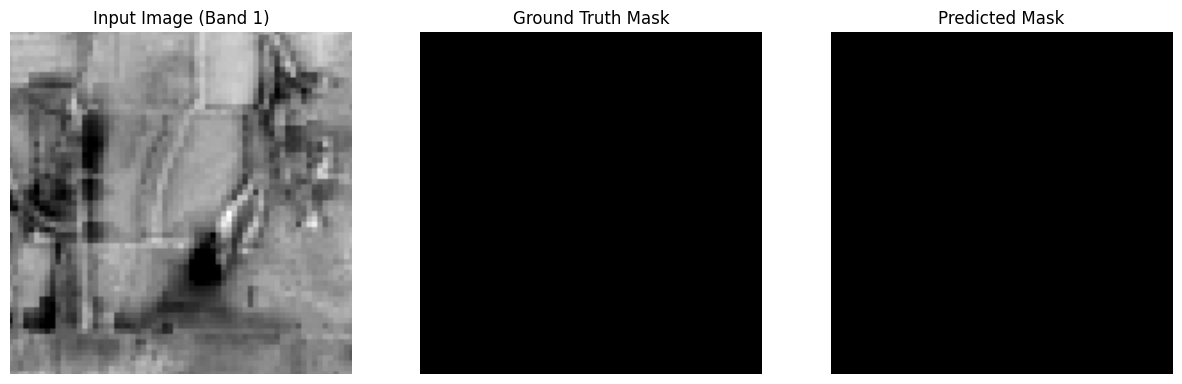

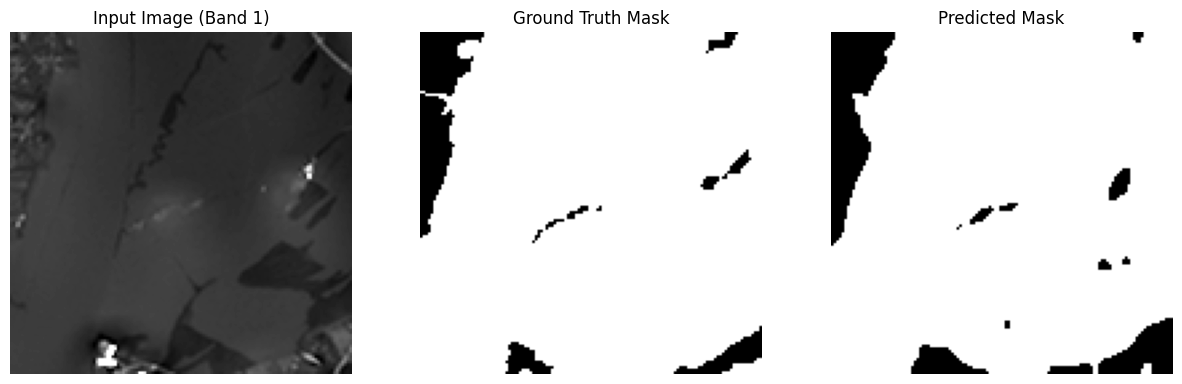

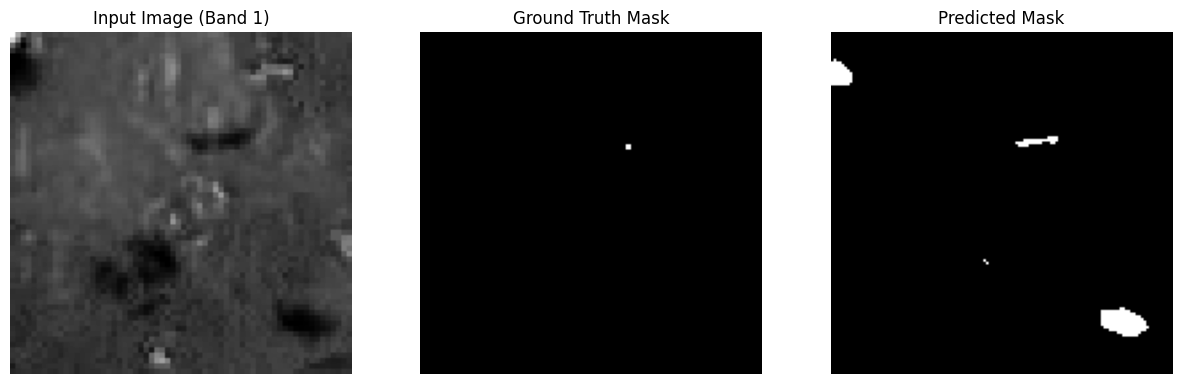

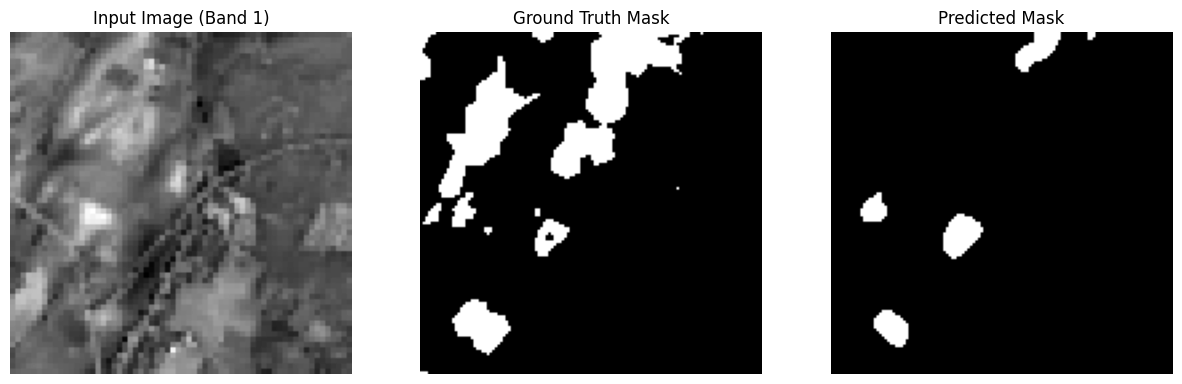

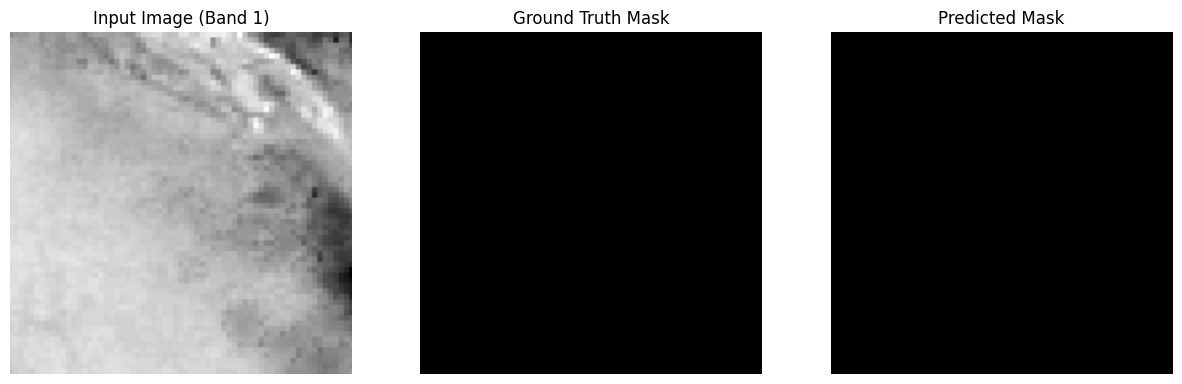

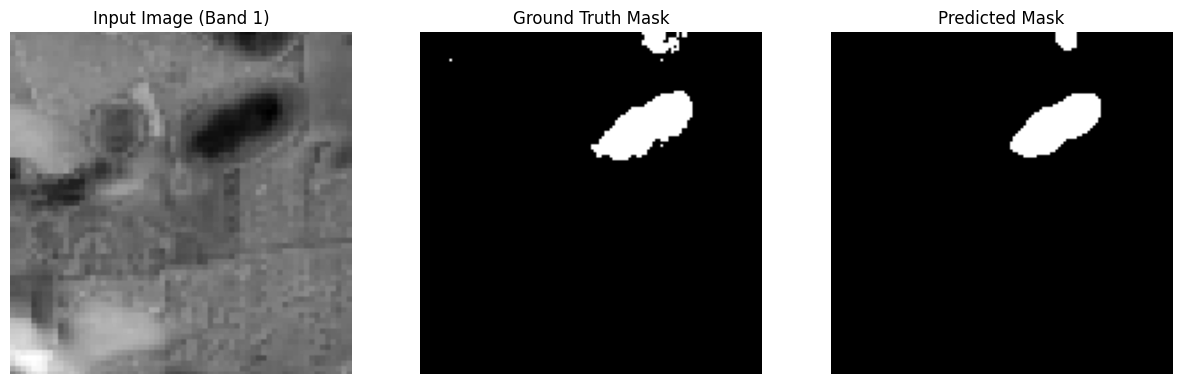

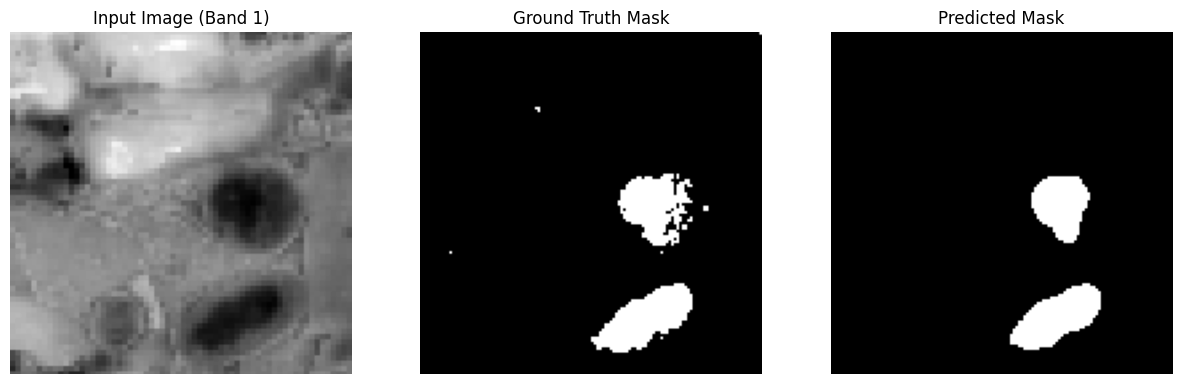

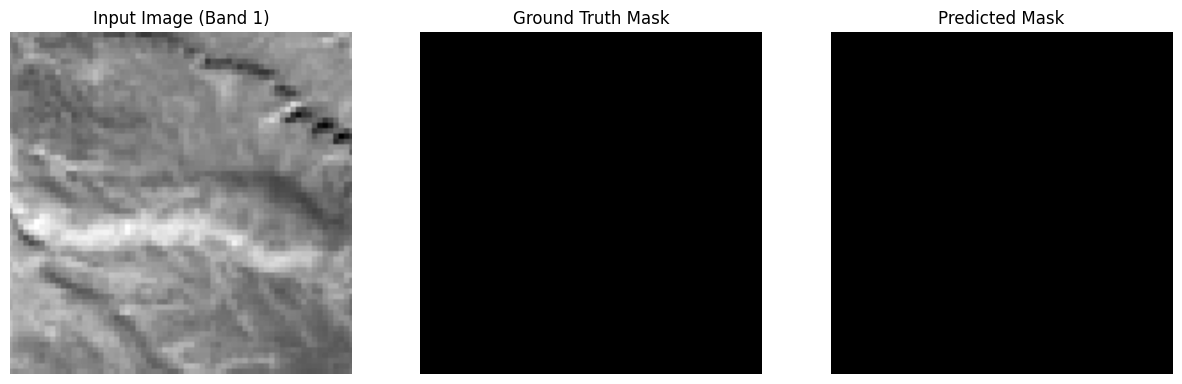

In [15]:
# Select a few test samples (e.g., first 3)
num_samples = 8
sample_images, sample_masks = next(iter(test_loader))
sample_images = sample_images[:num_samples].to(device)
sample_masks = sample_masks[:num_samples].to(device)

# Generate predictions
with torch.no_grad():
    sample_preds = model(sample_images)
    sample_preds = (torch.sigmoid(sample_preds) > threshold).float()

# Move to CPU for plotting
sample_images = sample_images.cpu()
sample_masks = sample_masks.cpu()
sample_preds = sample_preds.cpu()

# Plot each sample
for i in range(num_samples):
    plt.figure(figsize=(15, 5))
    
    # Input image (first band)
    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i, 0], cmap='gray')
    plt.title('Input Image (Band 1)')
    plt.axis('off')
    
    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(sample_masks[i, 0], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(sample_preds[i, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.show()

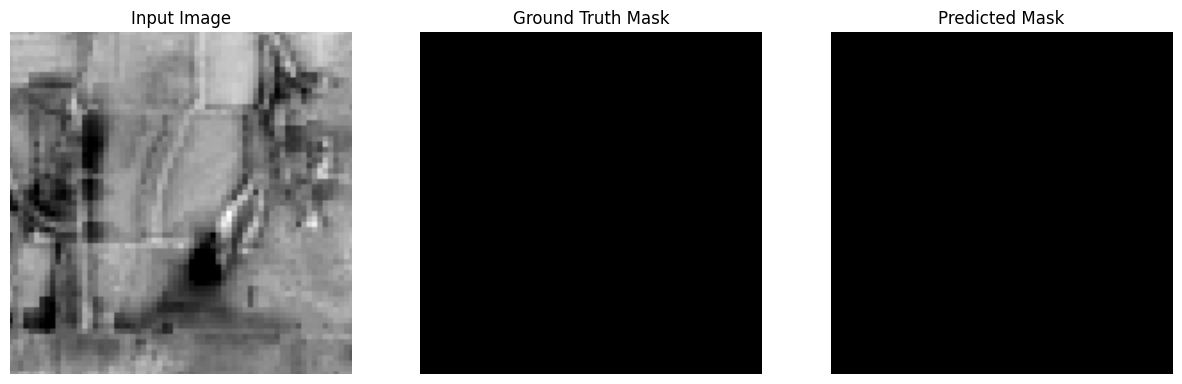

In [16]:
# Assuming you have a test_loader and a trained model
model.eval()
with torch.no_grad():
    for images, masks in test_loader:  # Replace test_loader with your data loader
        images = images.to(device)     # device = 'cuda' or 'cpu'
        masks = masks.to(device)
        preds = model(images)          # Get predictions
        preds = (torch.sigmoid(preds) > 0.5).float()  # Threshold to binary mask
        
        # Plot the first example in the batch
        plt.figure(figsize=(15, 5))
        
        # Input Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[0].cpu().permute(1, 2, 0)[:, :, 0], cmap='gray')
        plt.title('Input Image')
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[0].cpu().squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(preds[0].cpu().squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()
        break  # Show only one batch

In [17]:
# Save the model's weights
save_path = 'unet_model.pth'
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

# Optional: Save the entire model (less recommended)
full_save_path = 'unet_full_model.pth'
torch.save(model, full_save_path)
print(f"Full model saved to {full_save_path}")

Model weights saved to unet_model.pth
Full model saved to unet_full_model.pth


In [18]:
#model = UNet(in_channels=12, out_channels=1)
#model.load_state_dict(torch.load('unet_model.pth'))
#model.to(device)

In [19]:
#model = torch.load('unet_full_model.pth')
#model.to(device)

In [32]:
model = torch.load('unet_model.pth', map_location=device)


C:\Users\Dell\AppData\Local\Temp\ipykernel_18208\4151736899.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('unet_model.pth', map_location=device)


In [34]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# تحميل النموذج بالكامل
model = torch.load('unet_full_model.pth', map_location=device)

# حفظ الـ state_dict فقط
torch.save(model.state_dict(), 'unet_corrected.pth')

print("Model state_dict saved successfully!")


Model state_dict saved successfully!


C:\Users\Dell\AppData\Local\Temp\ipykernel_18208\3855352091.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('unet_full_model.pth', map_location=device